In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
np.random.seed(42)

In [3]:
#store the path of the drug-metabolite file
path = 'C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\Integrated Analysis with Rep Meta\\Datasets\\ACETOXYPHENANTHRYLMERCURY_integrated.csv'

In [4]:
#extract the name of the drug

dr = path.split('\\')[-1]
drug_name = dr.split('_')[0]
drug_name

'ACETOXYPHENANTHRYLMERCURY'

In [5]:
#read the input drug-metabolite integrated data
data = pd.read_csv(path)

In [6]:
data.head(2)

,Cell Line,Acetone ; Propanal ; acetone,Acetaldehyde oxime ; HMDB01122,acetate,Urea,Isopropyl alcohol ; Propyl alcohol,Bicarbonate ; Hydrogen carbonate,Dimethylsulfide,3-Butyn-1-al,1-pyrrolinium,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,Breast_BT549,0.021811,0.006137,1.801231,0.178675,0.031762,0.143416,0.004437,0.001118,0.002353,...,1.93205,3.74886,0.452336,0.940899,2.78817,0.493042,1.21729,36.0483,2.49718,2.30652
1,Breast_HS578T,0.010611,0.006815,0.884542,0.093390,0.016027,0.037372,NaN,0.005778,0.003199,...,1.96807,3.22352,0.157620,0.343406,2.11181,0.135277,1.42039,103.5290,1.27063,1.64715


In [7]:
#drop the target drug column
drug = data.pop(f'{drug_name}')

In [8]:
#read the representative set of metabolites

with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\ModelRunNTimes\\outputs\\representative_metabolites.txt', 'r+') as f:
    rep_meta = f.read().strip().splitlines()
    
#read the genes

with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\Integrated Analysis with Rep Meta\\list_of_genes.txt', 'r+') as f:
     rep_genes = f.read().strip().splitlines()   
     
rep_genes.extend(rep_meta)

In [9]:
#read the representative set of metabolites

with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\ModelRunNTimes\\outputs\\representative_metabolites.txt', 'r+') as f:
    rep_meta = f.read().strip().splitlines()
    
#read the genes

with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\Integrated Analysis with Rep Meta\\list_of_genes.txt', 'r+') as f:
     rep_genes = f.read().strip().splitlines()   
     
rep_genes.extend(rep_meta)

In [10]:
len(rep_meta), len(rep_genes)

(197, 24023)

In [11]:
#select the input features, drop all metadata
X = data.select_dtypes('float64')

#select only the representative metabolites and the gene expression profiles
X = X[rep_genes]

#fill the NaNs with mean of each column
X.fillna(X.mean(), inplace=True)

In [12]:
X.shape

(52, 24023)

In [13]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

In [14]:
#create empty list to store labels and take mean of the response values
#if response value is greater than mean then store 'NR' else store 'R'
#convert the list of labels into a Series

target, drug_mean = [], drug.mean()
for i in drug:
    if i > drug_mean:
        target.append('NR')
    else:
        target.append('R')
y = pd.Series(target)

In [15]:
X.shape, y.shape

((52, 24023), (52,))

In [16]:
#initialize the LabelEncoder instance
le = LabelEncoder()

#encode the labels into 0 and 1 for NR and R respectively
y = pd.Series(le.fit_transform(y))
y.value_counts()

0    43
1     9
dtype: int64

In [17]:
#initialize SMOTE instance
smote = SMOTE()

#use SMOTE to create synthetic samples to create a balanced set of data
X, y = smote.fit_resample(X, y)

In [18]:
#initialize StandardScaler for normalization of input features
scaler = StandardScaler()

#normalize the input dataframe
X = pd.DataFrame(data = scaler.fit_transform(X), columns = X.columns)
X.head(2)

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Theaflavin-3-gallate,"PC(14:0/18:4(6Z,9Z,12Z,15Z)) ; PC(14:1(9Z)/18:3(6Z,9Z,12Z)) ; PC(14:1(9Z)/18:3(9Z,12Z,15Z)) ; PC(18:3(6Z,9Z,12Z)/14:1(9Z)) ; PC(18:3(9Z,12Z,15Z)/14:1(9Z)) ; PC(18:4(6Z,9Z,12Z,15Z)/14:0) ; PE(15:0/20:4(5Z,8Z,11Z,14Z)) ; PE(15:0/20:4(8Z,11Z,14Z,17Z)) ; PE(20:4(5Z,8Z,11Z,14Z)/15:0) ; PE(20:4(8Z,11Z,14Z,17Z)/15:0)",Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8
0,5.280848,1.154220,-0.003334,-0.033094,0.000434,-0.173667,0.054192,0.086031,2.200402,0.205587,...,-1.266103,-1.096745,-0.479500,-1.129161,0.989038,-1.166502,-0.579969,0.436974,-0.771051,1.493246
1,2.569132,0.210491,-0.237081,-0.317865,0.000434,-0.312508,0.054192,0.086031,-1.233740,5.827848,...,-0.910152,-0.182309,-1.220478,-0.197826,-1.007157,-1.024835,-1.323212,-2.354767,-1.692834,1.090070


In [19]:
X.shape, y.shape

((86, 24023), (86,))

In [20]:
y.value_counts()

0    43
1    43
dtype: int64

In [21]:
X.head(2)

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Theaflavin-3-gallate,"PC(14:0/18:4(6Z,9Z,12Z,15Z)) ; PC(14:1(9Z)/18:3(6Z,9Z,12Z)) ; PC(14:1(9Z)/18:3(9Z,12Z,15Z)) ; PC(18:3(6Z,9Z,12Z)/14:1(9Z)) ; PC(18:3(9Z,12Z,15Z)/14:1(9Z)) ; PC(18:4(6Z,9Z,12Z,15Z)/14:0) ; PE(15:0/20:4(5Z,8Z,11Z,14Z)) ; PE(15:0/20:4(8Z,11Z,14Z,17Z)) ; PE(20:4(5Z,8Z,11Z,14Z)/15:0) ; PE(20:4(8Z,11Z,14Z,17Z)/15:0)",Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8
0,5.280848,1.154220,-0.003334,-0.033094,0.000434,-0.173667,0.054192,0.086031,2.200402,0.205587,...,-1.266103,-1.096745,-0.479500,-1.129161,0.989038,-1.166502,-0.579969,0.436974,-0.771051,1.493246
1,2.569132,0.210491,-0.237081,-0.317865,0.000434,-0.312508,0.054192,0.086031,-1.233740,5.827848,...,-0.910152,-0.182309,-1.220478,-0.197826,-1.007157,-1.024835,-1.323212,-2.354767,-1.692834,1.090070


In [22]:
#find the indices of the input dataset
indices = X.index.values

#split the dataset into train and test datasets
X_train, X_test, train_index, test_index = train_test_split(X, indices, test_size = 0.20, random_state = 43)
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [23]:
X_train.shape, X_test.shape

((68, 24023), (18, 24023))

In [24]:
y_train.value_counts(), y_test.value_counts()

(0    34
 1    34
 dtype: int64,
 1    9
 0    9
 dtype: int64)

In [25]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction = []

#define a list to store the number of features being selected each run
num_features = []

#define the model
model = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced')

#define a list to store accuracy, precision and recall 
acc_score, rec_score, pre_score = [], [], []


#run the feature selection and model training and evaluation N times
for i in range(N): 
    #define base estimator for feature selection and fit the training data to it
    base_estimator = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SelectFromModel to select features based on base estimator provided and use the mean of the feature importances
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train and test data using SFM
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X.columns[sfm.get_support(1)])
    
    print(f'Number of features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features.append(len(X_train.columns))
    
    #define the machine learning model and train it
    model.fit(X_train_new, y_train)
    
    #make predictions and other metrics
    y_pred = model.predict(X_test_new)
    acc_score.append(accuracy_score(y_test, y_pred))
    rec_score.append(recall_score(y_test, y_pred, pos_label=1))
    pre_score.append(precision_score(y_test, y_pred, pos_label=1))
    
    #store the probabilites of each run
    prediction.append(model.predict_proba(X_test_new))

    
acc_score = np.array(acc_score)
rec_score = np.array(rec_score)
pre_score = np.array(pre_score)
print(f'Accuracy score: {np.mean(acc_score)}, Standard deviation: {np.std(acc_score)}')
print(f'Recall score: {np.mean(rec_score)}, Standard deviation: {np.std(rec_score)}')
print(f'Precision score: {np.mean(pre_score)}, Standard deviation: {np.std(pre_score)}')

#indice = np.unique(np.array(indice))
prediction = np.array(prediction)
prediction = np.mean(prediction, axis=0)[:, 1]

Number of features selected during iteration 0: 494
Number of features selected during iteration 1: 522
Number of features selected during iteration 2: 520
Number of features selected during iteration 3: 482
Number of features selected during iteration 4: 491
Number of features selected during iteration 5: 489
Number of features selected during iteration 6: 485
Number of features selected during iteration 7: 500
Number of features selected during iteration 8: 496
Number of features selected during iteration 9: 501
Number of features selected during iteration 10: 488
Number of features selected during iteration 11: 522
Number of features selected during iteration 12: 481
Number of features selected during iteration 13: 476
Number of features selected during iteration 14: 500
Number of features selected during iteration 15: 503
Number of features selected during iteration 16: 476
Number of features selected during iteration 17: 512
Number of features selected during iteration 18: 491
Num

In [26]:
features = list(X_train_new.columns)
count = 0
for i in features:
    if i in rep_meta:
        count+=1 #get the number of metabolites selected from the represented features
count, len(features) - count #count the number of genes 

(6, 505)

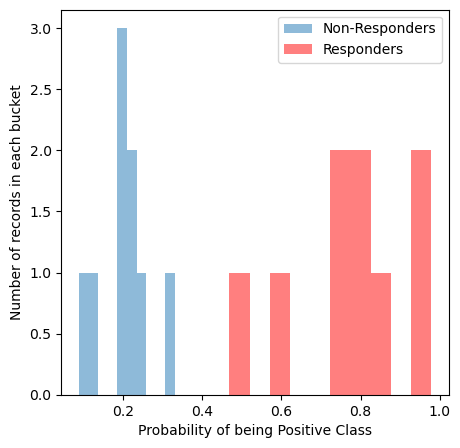

In [27]:
plt.figure(figsize=(5, 5))
plt.hist(prediction[y_test==0], label='Non-Responders', alpha = 0.5)
plt.hist(prediction[y_test==1], label='Responders', alpha=0.5, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [28]:
df_rf_test = X_test.copy()
df_rf_test.loc[test_index, 'test_proba'] = prediction
df_rf_test.loc[test_index, 'target'] = y
df1 = pd.concat([X_train, df_rf_test], sort=False).sort_index()

In [29]:
df1

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,5.280848,1.154220,-0.003334,-0.033094,0.000434,-0.173667,0.054192,0.086031,2.200402,0.205587,...,-0.479500,-1.129161,0.989038,-1.166502,-0.579969,0.436974,-0.771051,1.493246,0.188400,0.0
1,2.569132,0.210491,-0.237081,-0.317865,0.000434,-0.312508,0.054192,0.086031,-1.233740,5.827848,...,-1.220478,-0.197826,-1.007157,-1.024835,-1.323212,-2.354767,-1.692834,1.090070,0.187333,0.0
2,-0.395891,-1.104002,-0.333481,-0.318864,0.000434,-0.405857,0.054192,-0.602615,-1.325870,0.205587,...,-0.034218,-1.016547,-0.115111,-1.050987,-0.427538,-0.549854,-0.650997,0.056720,0.606400,1.0
3,2.936080,0.814630,-0.357305,-0.319514,-0.534918,-0.173667,0.054192,-0.379910,-0.996190,0.205587,...,-0.207523,-0.435315,0.431346,0.277264,-0.524616,-0.863980,0.563375,-0.578102,NaN,NaN
4,1.923359,-1.038305,-0.003334,-0.317253,0.000434,-0.173667,0.054192,-0.271486,-1.248152,0.021714,...,-1.309853,0.004480,-1.829174,1.208133,-2.317125,-0.679332,-1.192160,0.218206,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,-0.325601,0.126720,-0.346651,-0.068325,-0.244564,-0.404220,0.054192,0.086031,1.039063,-0.570505,...,-0.333768,-1.047814,-0.468008,-1.317752,-0.824850,-0.169875,-0.692266,-0.158033,NaN,NaN
82,0.029046,0.899791,-0.355165,1.108493,0.763041,-0.404599,0.054192,0.086031,0.458087,-0.143158,...,-0.383288,-1.060246,-0.784114,-1.159766,-0.381954,-0.419063,-0.642079,-0.757077,NaN,NaN
83,-0.006503,-0.546056,-0.031364,-0.132210,0.124254,-0.191733,0.054192,-0.472516,0.978076,0.205587,...,-0.379436,2.784085,0.441674,-0.726043,0.367306,-0.785166,-0.624624,0.879850,NaN,NaN
84,-0.478128,-0.026117,-0.243848,-0.318605,-0.504912,4.228746,0.054192,-0.552345,0.084548,0.205587,...,-0.150802,-0.660842,0.831820,0.142154,0.823753,-0.304336,-0.113762,-0.695635,NaN,NaN


In [30]:
df1_main = df1.iloc[:51, ]
x = max(prediction[y_test == 0])
df1_main = df1_main.loc[(df1_main['test_proba'] > x)]
df1_main.shape

(4, 24025)

In [31]:
df1_main.index.values #0 40 41 42

array([ 2, 11, 15, 39], dtype=int64)

In [32]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction2 = []

#define a list to store the number of features selected in each iteration
num_features2 = []

#define a list to store accuracy, precision and recall 
model2 = SVC(C=1, gamma=1, probability=True)
acc_score2, rec_score2, pre_score2 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define the base estimator for feature selection
    base_estimator = RandomForestClassifier(n_estimators=150, class_weight='balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute the importances of each feature
    importances = base_estimator.feature_importances_
    
    #use SelectFromModel and mean importances to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train-test data using important features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_train.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features2.append(len(X_train_new.columns))

    #define the SVM model and train it
    model2.fit(X_train_new, y_train)
    
    #comput predictions
    y_pred2 = model2.predict(X_test_new)
    acc_score2.append(accuracy_score(y_test, y_pred2))
    rec_score2.append(recall_score(y_test, y_pred2, pos_label=1))
    pre_score2.append(precision_score(y_test, y_pred2, pos_label=1))
    prediction2.append(model2.predict_proba(X_test_new))


acc_score2 = np.array(acc_score2)
rec_score2 = np.array(rec_score2)
pre_score2 = np.array(pre_score2)
print(f'Accuracy score: {np.mean(acc_score2)}, Standard deviation: {np.std(acc_score2)}')
print(f'Recall score: {np.mean(rec_score2)}, Standard deviation: {np.std(rec_score2)}')
print(f'Precision score: {np.mean(pre_score2)}, Standard deviation: {np.std(pre_score2)}')


prediction2 = np.array(prediction2)
prediction2 = np.mean(prediction2, axis=0)[:, 1]

Features selected during iteration 0: 490
Features selected during iteration 1: 491
Features selected during iteration 2: 501
Features selected during iteration 3: 517
Features selected during iteration 4: 509
Features selected during iteration 5: 496
Features selected during iteration 6: 485
Features selected during iteration 7: 499
Features selected during iteration 8: 499
Features selected during iteration 9: 504
Features selected during iteration 10: 529
Features selected during iteration 11: 489
Features selected during iteration 12: 513
Features selected during iteration 13: 498
Features selected during iteration 14: 496
Features selected during iteration 15: 501
Features selected during iteration 16: 496
Features selected during iteration 17: 506
Features selected during iteration 18: 496
Features selected during iteration 19: 492
Features selected during iteration 20: 492
Features selected during iteration 21: 511
Features selected during iteration 22: 502
Features selected dur

In [33]:
print(f'Average number of features being selected: {np.mean(num_features2)}')

Average number of features being selected: 499.0


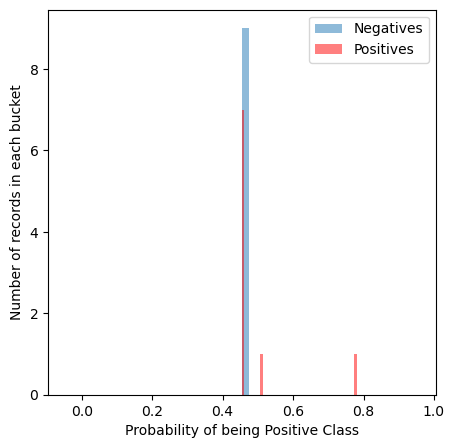

In [34]:
plt.figure(figsize=(5,5))
plt.hist(prediction2[y_test==0], label='Negatives', alpha = 0.5, bins = 50)
plt.hist(prediction2[y_test==1], label='Positives', alpha=0.5, bins = 50, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [35]:
df_svm_test = X_test.copy()
df_svm_test.loc[test_index, 'test_proba'] = prediction2
df_svm_test.loc[test_index, 'target'] = y_test
df2 = pd.concat([X_train, df_svm_test], sort=False).sort_index()

In [36]:
df2_main = df2.iloc[:51, ]
df2_main = df2_main.loc[(df2_main['test_proba'] > max(prediction2[y_test == 0]))]
df2_main

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
11,-0.707915,0.041447,0.762022,-0.318491,-0.522195,-0.173667,0.054192,0.086031,1.655361,0.205587,...,-0.652252,0.129569,-0.911312,2.174901,0.056129,0.350990,0.122415,-1.487495,0.454713,1.0
15,-0.521242,0.041447,-0.267198,-0.318592,-0.553972,4.656148,0.054192,-0.555500,-0.010378,0.205587,...,-0.128970,-1.027001,0.857489,0.223934,0.864876,-0.256317,-0.063972,-0.866079,0.459110,1.0


In [37]:
df2_main.index.values #40 41 42

array([11, 15], dtype=int64)

In [38]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction3 = []

#define a list to store the number of features being selected in each iteration
num_features3 = []

#define the XGBoost model
model3 = XGBClassifier()

#define a list to store accuracy, precision and recall 
acc_score3, rec_score3, pre_score3 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define base estimator to compute feature importances
    base_estimator = XGBClassifier()
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SFM model to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform train and test sets using best features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_test.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features3.append(len(X_train_new.columns))

    #define XGBoost model and train it
    model3.fit(X_train_new, y_train)
    
    #compute predictions
    y_pred3 = model3.predict(X_test_new)
    acc_score3.append(accuracy_score(y_test, y_pred3))
    rec_score3.append(recall_score(y_test, y_pred3, pos_label=1))
    pre_score3.append(precision_score(y_test, y_pred3, pos_label=1))
    prediction3.append(model3.predict_proba(X_test_new))


acc_score3 = np.array(acc_score3)
rec_score3 = np.array(rec_score3)
pre_score3 = np.array(pre_score3)
print(f'Accuracy score: {np.mean(acc_score3)}, Standard deviation: {np.std(acc_score3)}')
print(f'Recall score: {np.mean(rec_score3)}, Standard deviation: {np.std(rec_score3)}')
print(f'Precision score: {np.mean(pre_score3)}, Standard deviation: {np.std(pre_score3)}')


prediction3 = np.array(prediction3)
prediction3 = np.mean(prediction3, axis=0)[:, 1]

Features selected during iteration 0: 22
Features selected during iteration 1: 22
Features selected during iteration 2: 22
Features selected during iteration 3: 22
Features selected during iteration 4: 22
Features selected during iteration 5: 22
Features selected during iteration 6: 22
Features selected during iteration 7: 22
Features selected during iteration 8: 22
Features selected during iteration 9: 22
Features selected during iteration 10: 22
Features selected during iteration 11: 22
Features selected during iteration 12: 22
Features selected during iteration 13: 22
Features selected during iteration 14: 22
Features selected during iteration 15: 22
Features selected during iteration 16: 22
Features selected during iteration 17: 22
Features selected during iteration 18: 22
Features selected during iteration 19: 22
Features selected during iteration 20: 22
Features selected during iteration 21: 22
Features selected during iteration 22: 22
Features selected during iteration 23: 22
Fe

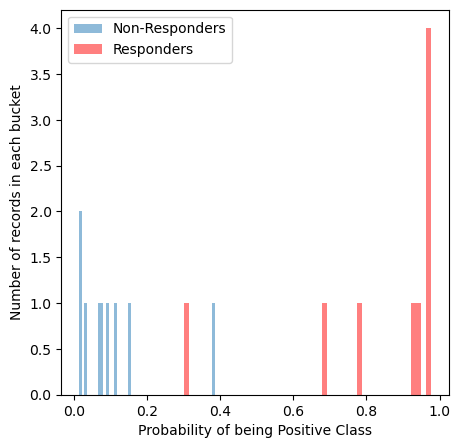

In [39]:
plt.figure(figsize=(5, 5))
plt.hist(prediction3[y_test==0], label='Non-Responders', bins = 50, alpha = 0.5)
plt.hist(prediction3[y_test==1], label='Responders', alpha=0.5, color='r', bins = 50)
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [40]:
df_xg = X_test.copy()
df_xg.loc[test_index, 'test_proba'] = prediction3
df_xg.loc[test_index, 'target'] = y_test
df3 = pd.concat([X_train, df_xg], sort=False).sort_index()
df3

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,5.280848,1.154220,-0.003334,-0.033094,0.000434,-0.173667,0.054192,0.086031,2.200402,0.205587,...,-0.479500,-1.129161,0.989038,-1.166502,-0.579969,0.436974,-0.771051,1.493246,0.018120,0.0
1,2.569132,0.210491,-0.237081,-0.317865,0.000434,-0.312508,0.054192,0.086031,-1.233740,5.827848,...,-1.220478,-0.197826,-1.007157,-1.024835,-1.323212,-2.354767,-1.692834,1.090070,0.014209,0.0
2,-0.395891,-1.104002,-0.333481,-0.318864,0.000434,-0.405857,0.054192,-0.602615,-1.325870,0.205587,...,-0.034218,-1.016547,-0.115111,-1.050987,-0.427538,-0.549854,-0.650997,0.056720,0.685692,1.0
3,2.936080,0.814630,-0.357305,-0.319514,-0.534918,-0.173667,0.054192,-0.379910,-0.996190,0.205587,...,-0.207523,-0.435315,0.431346,0.277264,-0.524616,-0.863980,0.563375,-0.578102,NaN,NaN
4,1.923359,-1.038305,-0.003334,-0.317253,0.000434,-0.173667,0.054192,-0.271486,-1.248152,0.021714,...,-1.309853,0.004480,-1.829174,1.208133,-2.317125,-0.679332,-1.192160,0.218206,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,-0.325601,0.126720,-0.346651,-0.068325,-0.244564,-0.404220,0.054192,0.086031,1.039063,-0.570505,...,-0.333768,-1.047814,-0.468008,-1.317752,-0.824850,-0.169875,-0.692266,-0.158033,NaN,NaN
82,0.029046,0.899791,-0.355165,1.108493,0.763041,-0.404599,0.054192,0.086031,0.458087,-0.143158,...,-0.383288,-1.060246,-0.784114,-1.159766,-0.381954,-0.419063,-0.642079,-0.757077,NaN,NaN
83,-0.006503,-0.546056,-0.031364,-0.132210,0.124254,-0.191733,0.054192,-0.472516,0.978076,0.205587,...,-0.379436,2.784085,0.441674,-0.726043,0.367306,-0.785166,-0.624624,0.879850,NaN,NaN
84,-0.478128,-0.026117,-0.243848,-0.318605,-0.504912,4.228746,0.054192,-0.552345,0.084548,0.205587,...,-0.150802,-0.660842,0.831820,0.142154,0.823753,-0.304336,-0.113762,-0.695635,NaN,NaN


In [41]:
df3_main = df3.iloc[:51, ]
df3_main = df3_main.loc[(df3_main['test_proba'] > max(prediction3[y_test == 0]))]
df3_main

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
2,-0.395891,-1.104002,-0.333481,-0.318864,0.000434,-0.405857,0.054192,-0.602615,-1.325870,0.205587,...,-0.034218,-1.016547,-0.115111,-1.050987,-0.427538,-0.549854,-0.650997,0.056720,0.685692,1.0
11,-0.707915,0.041447,0.762022,-0.318491,-0.522195,-0.173667,0.054192,0.086031,1.655361,0.205587,...,-0.652252,0.129569,-0.911312,2.174901,0.056129,0.350990,0.122415,-1.487495,0.927911,1.0
15,-0.521242,0.041447,-0.267198,-0.318592,-0.553972,4.656148,0.054192,-0.555500,-0.010378,0.205587,...,-0.128970,-1.027001,0.857489,0.223934,0.864876,-0.256317,-0.063972,-0.866079,0.964058,1.0


In [42]:
common_list = []
common_list.extend(list(df1_main.index.values))
common_list.extend(list(df2_main.index.values))
common_list.extend(list(df3_main.index.values))

In [43]:
cl = set(common_list)
cl

{2, 11, 15, 39}

In [44]:
df1_total = df1.loc[:51, ]
df1_total = df1_total.loc[(df1_total['target'] == 1.0)]
df1_total

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
2,-0.395891,-1.104002,-0.333481,-0.318864,0.000434,-0.405857,0.054192,-0.602615,-1.325870,0.205587,...,-0.034218,-1.016547,-0.115111,-1.050987,-0.427538,-0.549854,-0.650997,0.056720,0.6064,1.0
11,-0.707915,0.041447,0.762022,-0.318491,-0.522195,-0.173667,0.054192,0.086031,1.655361,0.205587,...,-0.652252,0.129569,-0.911312,2.174901,0.056129,0.350990,0.122415,-1.487495,0.7544,1.0
15,-0.521242,0.041447,-0.267198,-0.318592,-0.553972,4.656148,0.054192,-0.555500,-0.010378,0.205587,...,-0.128970,-1.027001,0.857489,0.223934,0.864876,-0.256317,-0.063972,-0.866079,0.8072,1.0
39,-0.609968,-1.126820,-0.240729,-0.317741,0.000434,-0.411311,0.054192,-0.605896,-1.439671,-1.971645,...,-1.265344,-0.132102,-0.748890,-0.510100,-1.338841,-1.741658,-1.420837,-0.658129,0.4684,1.0


In [45]:
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\Integrated Analysis with Rep Meta\\outputs\\master_list_metabolomics.txt', 'a+') as f:
    for i in cl:
        f.write(f'{i}\n')

In [46]:
l = []
l.extend(df1_total.index.values)
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\Integrated Analysis with Rep Meta\\outputs\\total_metabolomics.txt', 'a+') as f:
    for i in l:
        f.write(f'{i}\n')